In [1]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random

%matplotlib notebook

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]

In [4]:
df = load_region('county1000.csv')

In [5]:
data = np.asarray(df[DAYS_SUM[4]*24*4:DAYS_SUM[7]*24*4]).astype('float16').T

In [6]:
blds, t_len = data.shape

In [7]:
num_days = t_len//(24*4)
num_days

92

In [8]:
data_days = data.reshape(blds,num_days,24*4)

<IPython.core.display.Javascript object>


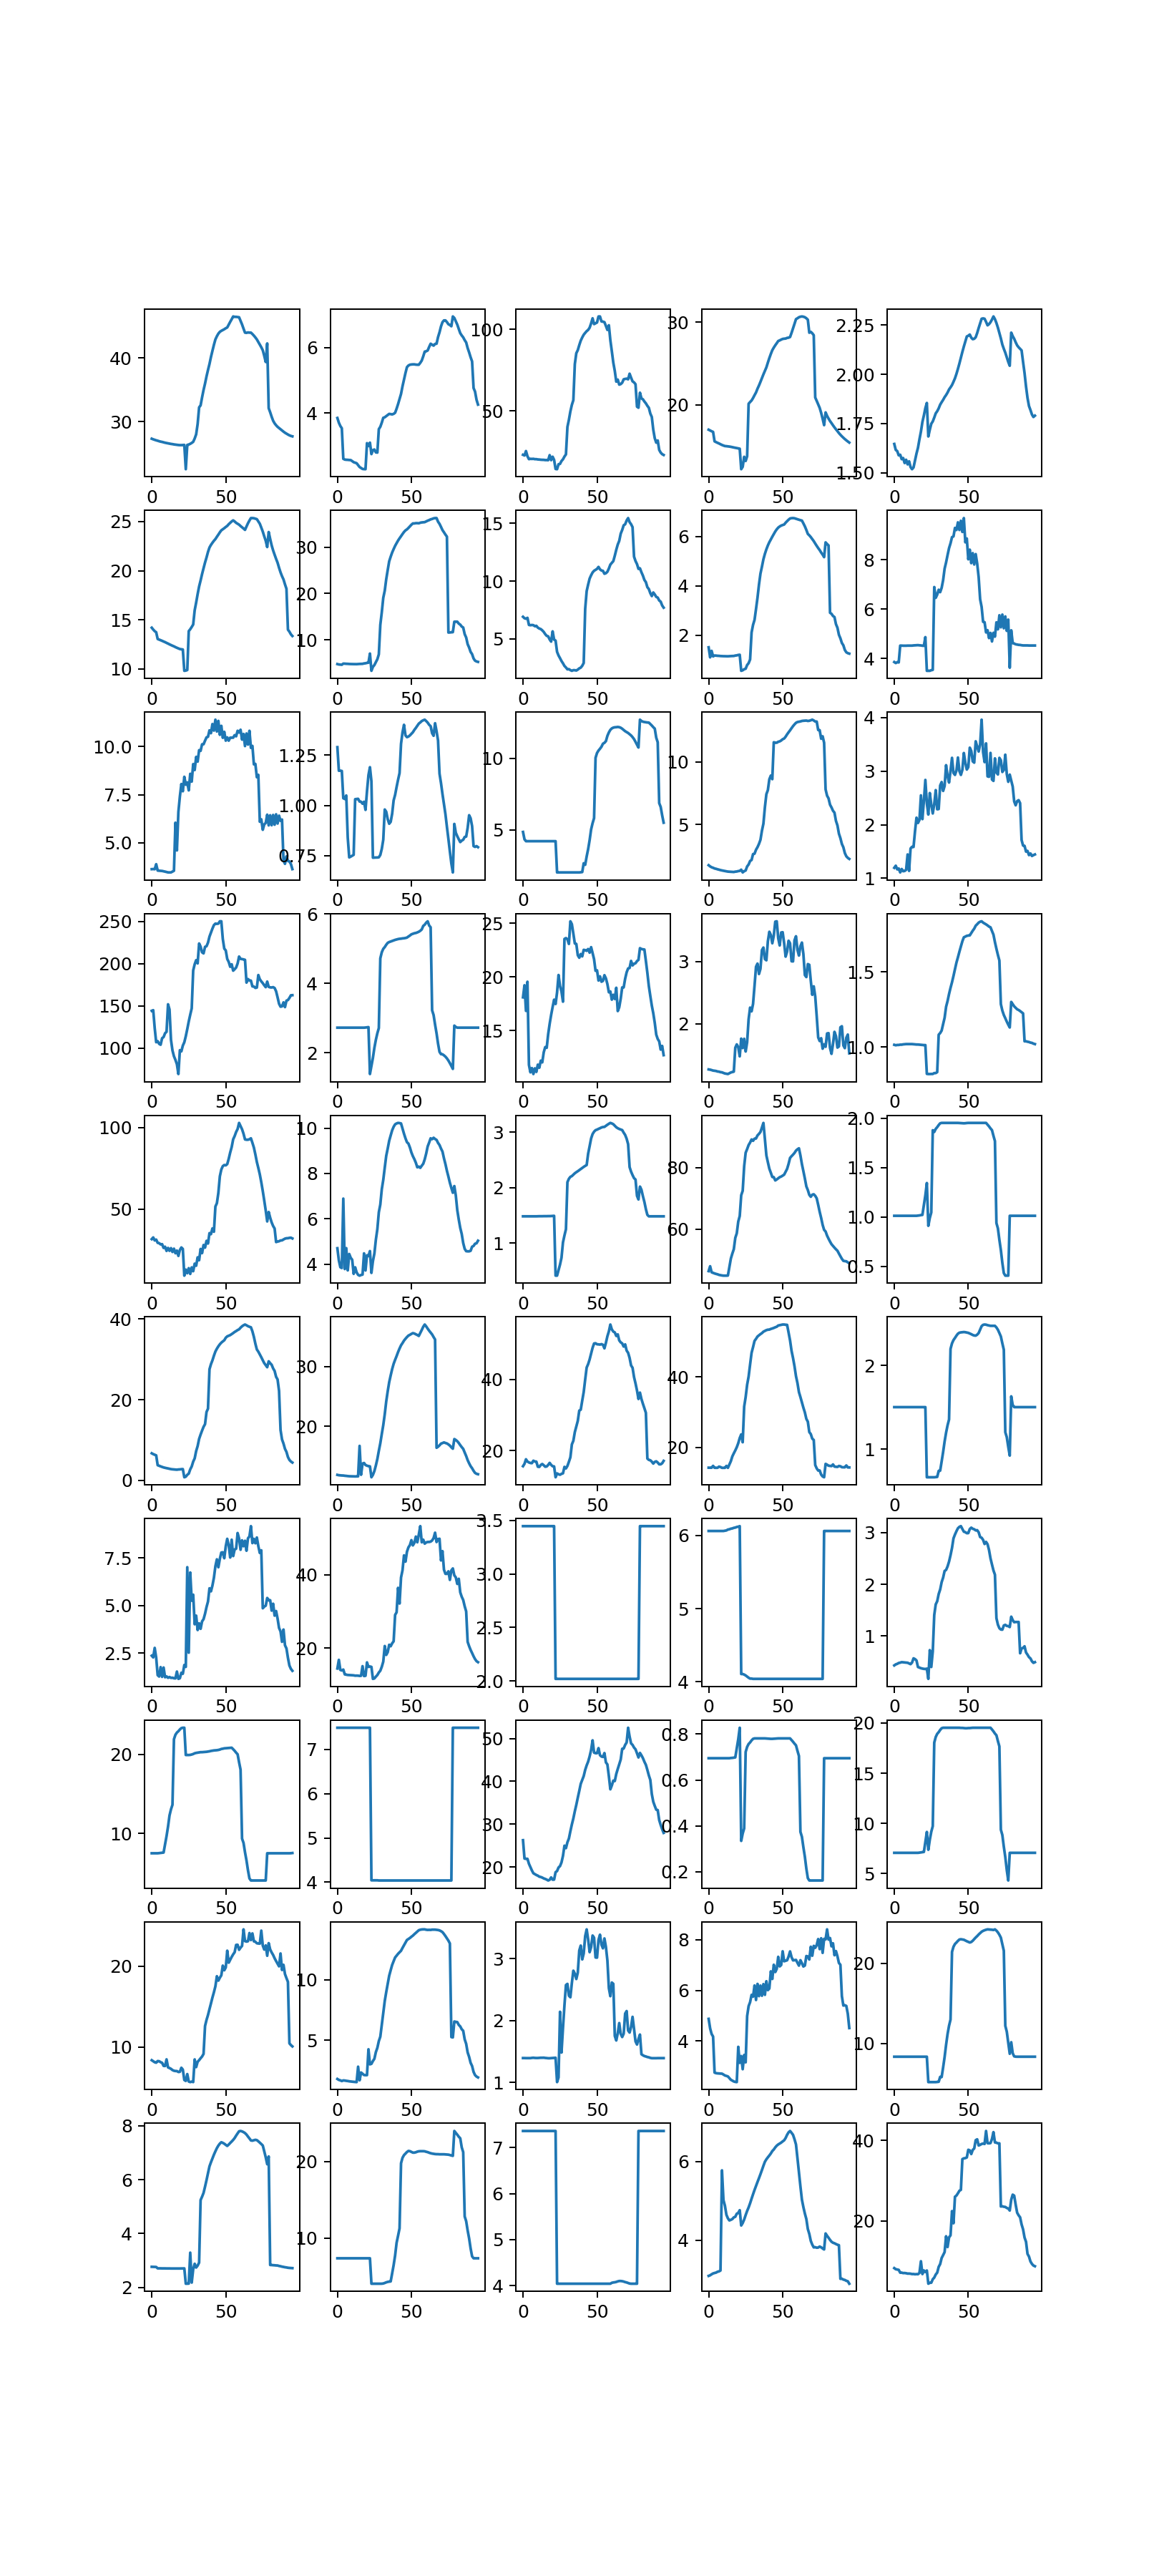

In [9]:
plt.subplots(10,5, figsize = (9,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])

In [9]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)

<IPython.core.display.Javascript object>


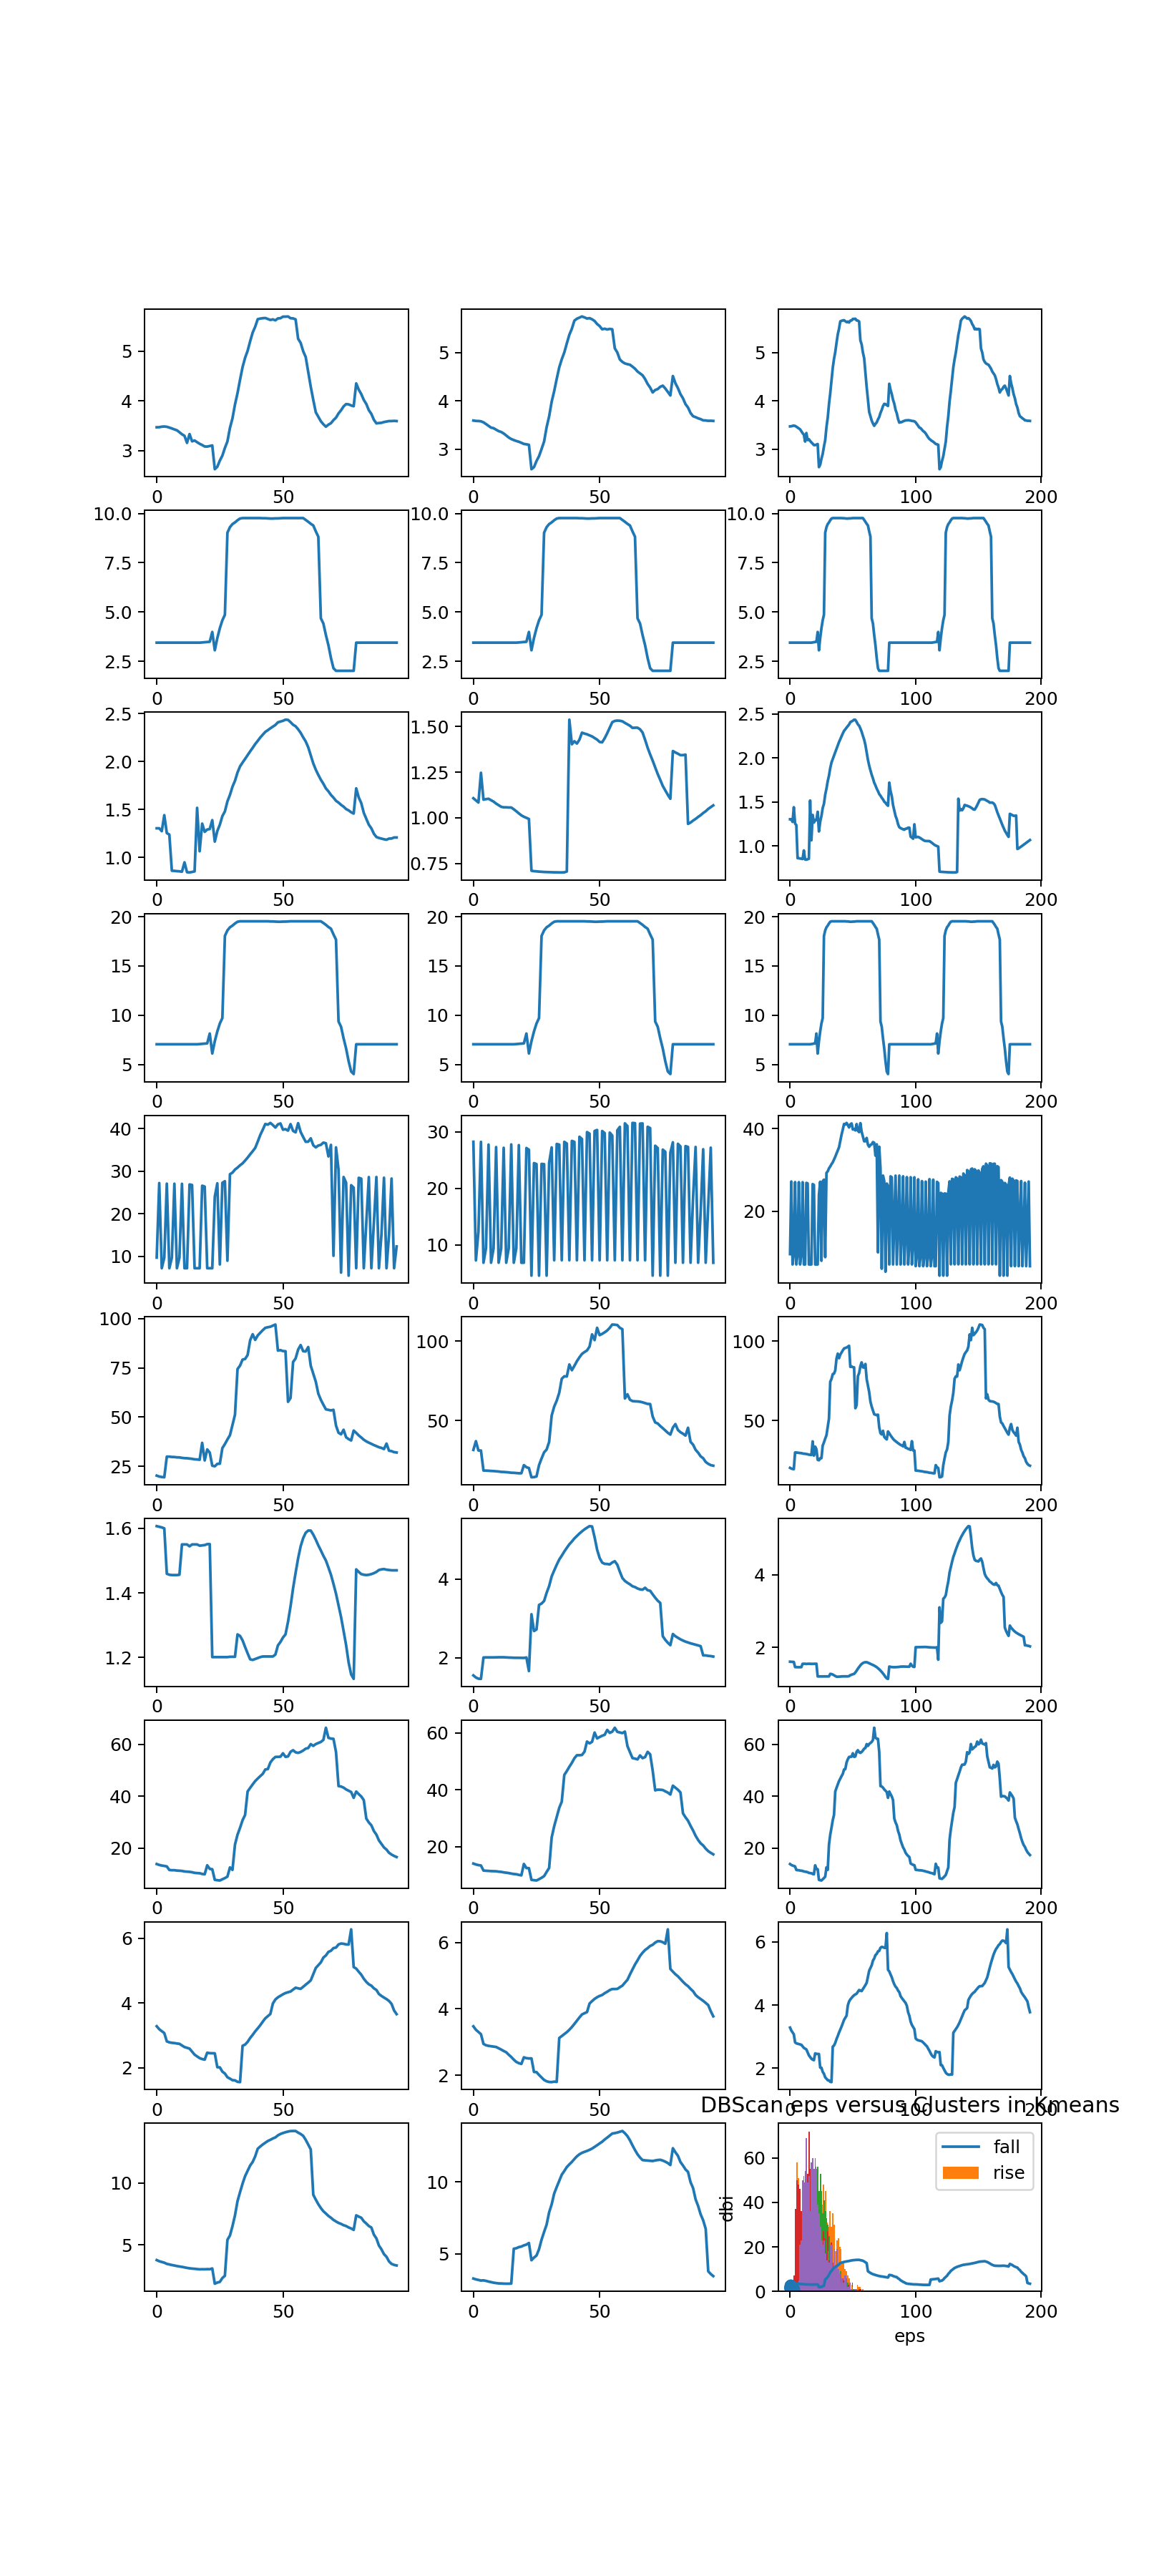

In [11]:
plt.subplots(10,3, figsize = (9,20))
for i in range(0,30,3):
    plt.subplot(10,3,i+1)
    bld = np.random.randint(0,blds)
    day = np.random.randint(0,num_days)
    plt.plot(data_days[bld,day,:])
    plt.subplot(10,3,i+2)
    plt.plot(data_days[bld,day+1,:])
    plt.subplot(10,3,i+3)
    plt.plot(two_days[bld,day,:])

In [10]:
def riseNfall(above,below):
    above = list((above))
    below = list((below))
    jumps = []
    ai,bi = 0,0
    start = True
    while (ai < len(above) and bi < len(below)):
        if above[ai] < below[bi]:
            jumps += [[above[ai], 1]]
            ai += 1
        else:
            jumps += [[below[bi], -1]]
            bi += 1
    jumps = np.asarray(jumps)
    rise,fall = 0,0
    for j in range(1,len(jumps)):
        if jumps[j,1] + jumps[j - 1, 1] == 0:
            diff = jumps[j,0] - jumps[j - 1, 0]
            if jumps[j, 1] < 0:
                fall = (diff)
            else:
                rise = (diff)
        if rise > 0 and fall > 0:
            break
    return jumps, rise,fall

<IPython.core.display.Javascript object>


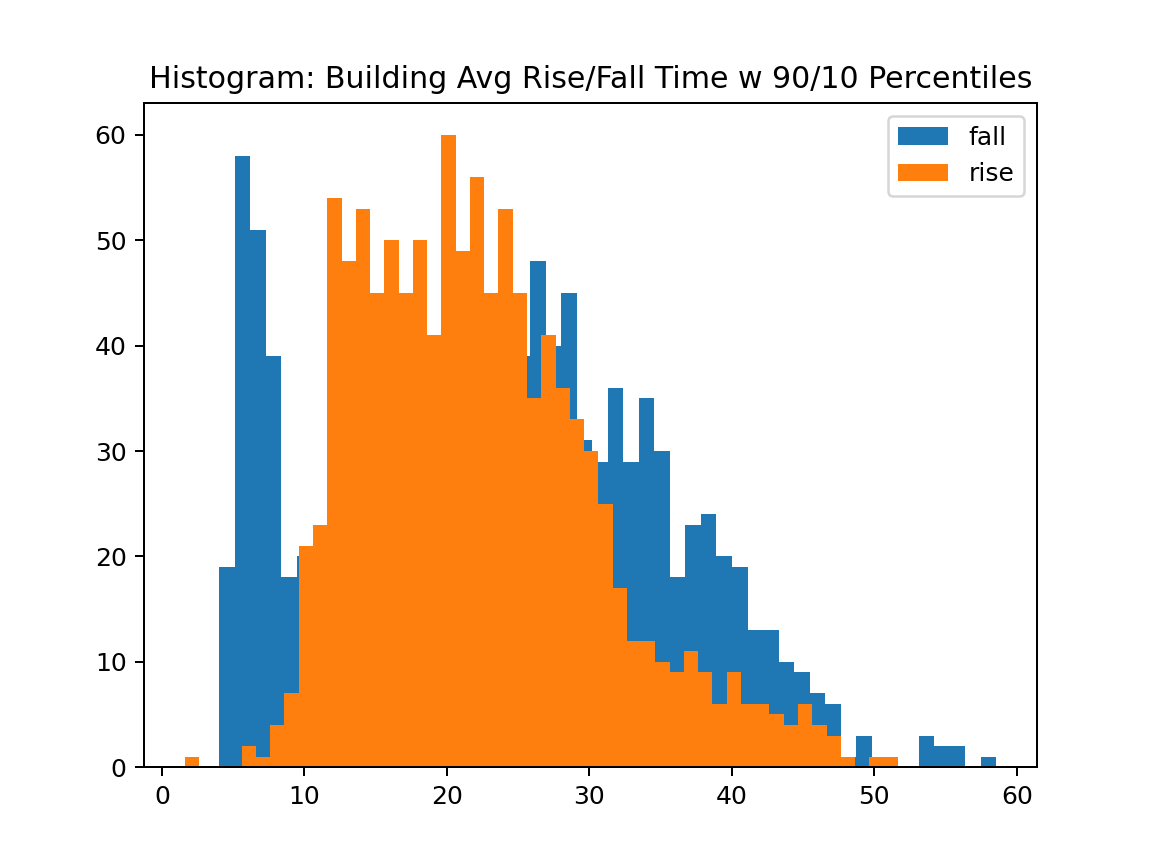

In [11]:
n_peak = np.percentile(two_days,90,axis=2,keepdims=True)
n_base = np.percentile(two_days,10,axis=2,keepdims=True)
high_load_dur = np.sum((two_days>.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

rise_times_days = np.zeros((blds,num_days-1))
fall_times_days = np.zeros((blds,num_days-1))
records = {}
for b in range(blds):
    records[b] = []
    for d in range(num_days-1):
        arr = two_days[b,d,:]
        above_peak = (arr>=n_peak[b,d,0]).astype(int)
        below_base = (arr<=n_base[b,d,0]).astype(int) 
        above_ind = np.nonzero(above_peak)[0]
        below_ind = np.nonzero(below_base)[0]
        jumps,rise,fall = riseNfall(above_ind,below_ind)
        rise_times_days[b,d] = rise
        fall_times_days[b,d] = fall
        records[b].append(jumps)
        
fall_times = np.mean(fall_times_days,axis=1)
rise_times = np.mean(rise_times_days,axis=1)

plt.hist(fall_times, bins = 50)
plt.hist(rise_times, bins = 50)
plt.title('Histogram: Building Avg Rise/Fall Time w 90/10 Percentiles')
plt.legend(['fall','rise'])
plt.show()

In [14]:
# n_peak = np.percentile(two_days,95,axis=2,keepdims=True)
# n_base = np.percentile(two_days,5,axis=2,keepdims=True)
# high_load_dur = np.sum((two_days>.5*(n_peak+n_base)).astype(int),axis=(1,2),keepdims=True)

# rise_times_days = np.zeros((blds,num_days-1))
# fall_times_days = np.zeros((blds,num_days-1))
# records = {}
# for b in range(blds):
#     records[b] = []
#     for d in range(num_days-1):
#         arr = two_days[b,d,:]
#         above_peak = (arr>=n_peak[b,d,0]).astype(int)
#         below_base = (arr<=n_base[b,d,0]).astype(int) 
#         above_ind = np.nonzero(above_peak)[0]
#         below_ind = np.nonzero(below_base)[0]
#         jumps,rise,fall = riseNfall(above_ind,below_ind)
#         rise_times_days[b,d] = rise
#         fall_times_days[b,d] = fall
#         records[b].append(jumps)
        
# fall_times = np.mean(fall_times_days,axis=1)
# rise_times = np.mean(rise_times_days,axis=1)

# plt.hist(fall_times, bins = 50)
# plt.hist(rise_times, bins = 50)
# plt.title('Histogram: Building Avg Rise/Fall Time w 95/5 Percentiles')
# plt.legend(['fall','rise'])
# plt.show()

In [12]:
params = (
    np.concatenate([np.mean(n_peak,axis=1),
                   np.mean(n_base,axis=1),
                   np.mean(high_load_dur,axis=1),
                   (fall_times).reshape(blds,1),
                   (rise_times).reshape(blds,1)]
                  ,axis=1))

In [13]:
params_n = (params-np.mean(params,keepdims=True,axis=0))/np.std(params,axis=0)

In [32]:
good_clust={}
for i in np.random.randn(200)*5:
    eps = np.round(np.exp(i)+1e-5,6)
    clust = DBSCAN(eps=eps).fit(params_n)
    if len(set(clust.labels_)) > 3:
        dbi = davies_bouldin_score(params_n, clust.labels_)
        print('eps: ',np.round(eps,4),'  dbi: ',np.round(dbi,4),'  clusters: ',len(set(clust.labels_)),'\n')
        good_clust[eps]=clust

eps:  0.5363   dbi:  1.9558   clusters:  5 

eps:  0.1954   dbi:  1.1802   clusters:  7 

eps:  0.3177   dbi:  1.8227   clusters:  19 

eps:  0.4846   dbi:  1.912   clusters:  6 

eps:  0.2036   dbi:  1.2697   clusters:  8 

eps:  0.3239   dbi:  1.7363   clusters:  17 

eps:  0.4456   dbi:  1.6496   clusters:  9 

eps:  0.3125   dbi:  1.8009   clusters:  21 

eps:  0.1751   dbi:  1.0192   clusters:  4 

eps:  0.3446   dbi:  1.799   clusters:  19 

eps:  0.5008   dbi:  1.6565   clusters:  9 

eps:  0.3012   dbi:  1.829   clusters:  21 



In [14]:
k_dbis = []
for i in range(90,130):
    clust = KMeans(i).fit(params_n)
    k_dbis.append(davies_bouldin_score(params_n, clust.labels_))
    #print(np.round(eps,4),set(clust.labels_))


<IPython.core.display.Javascript object>


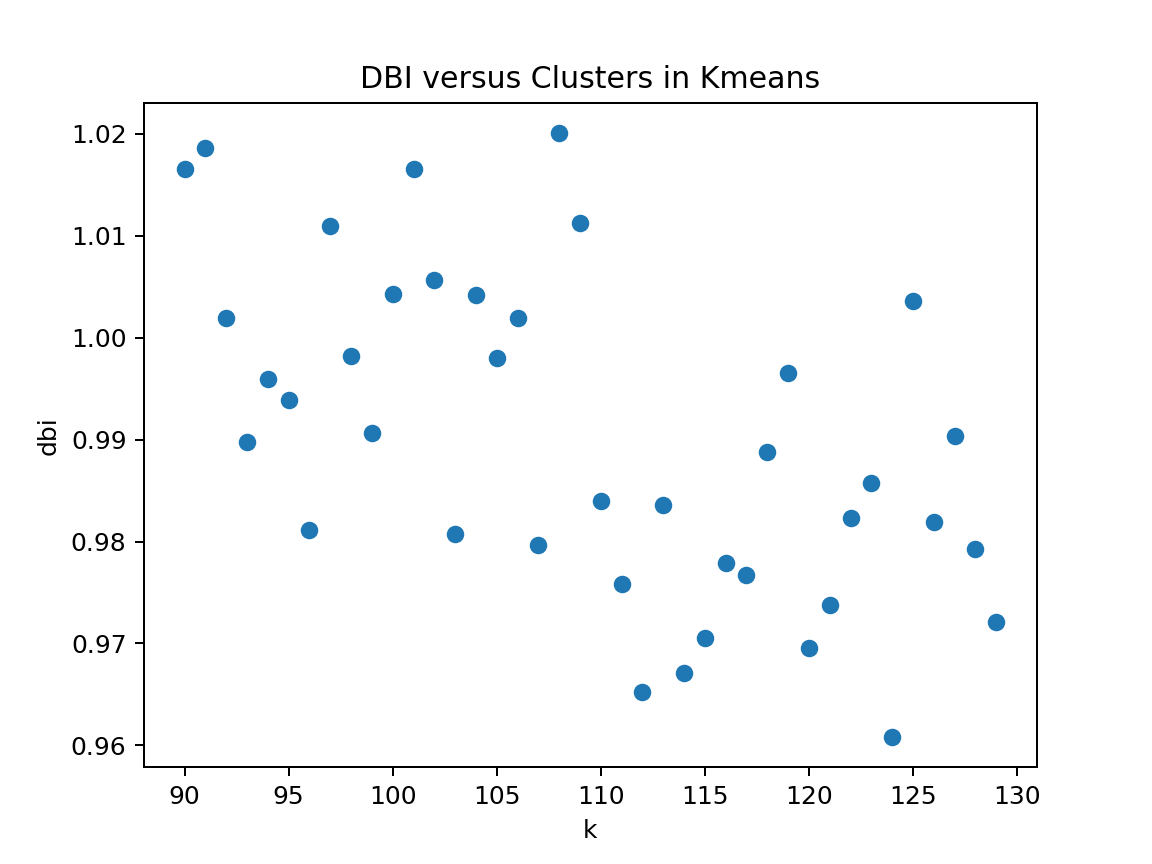

Text(0.5, 1.0, 'DBI versus Clusters in Kmeans')

In [17]:
plt.scatter(list(range(90,130)),k_dbis)
plt.xlabel('k')
plt.ylabel('dbi')
plt.title('DBI versus Clusters in Kmeans')

In [29]:
lst_eps = []
db_dbis = []

In [30]:
for j in good_clust.keys():
    lst_eps.append(j)
    labls = good_clust[j].labels_
    db_dbis.append(davies_bouldin_score(params_n, labls))

<IPython.core.display.Javascript object>


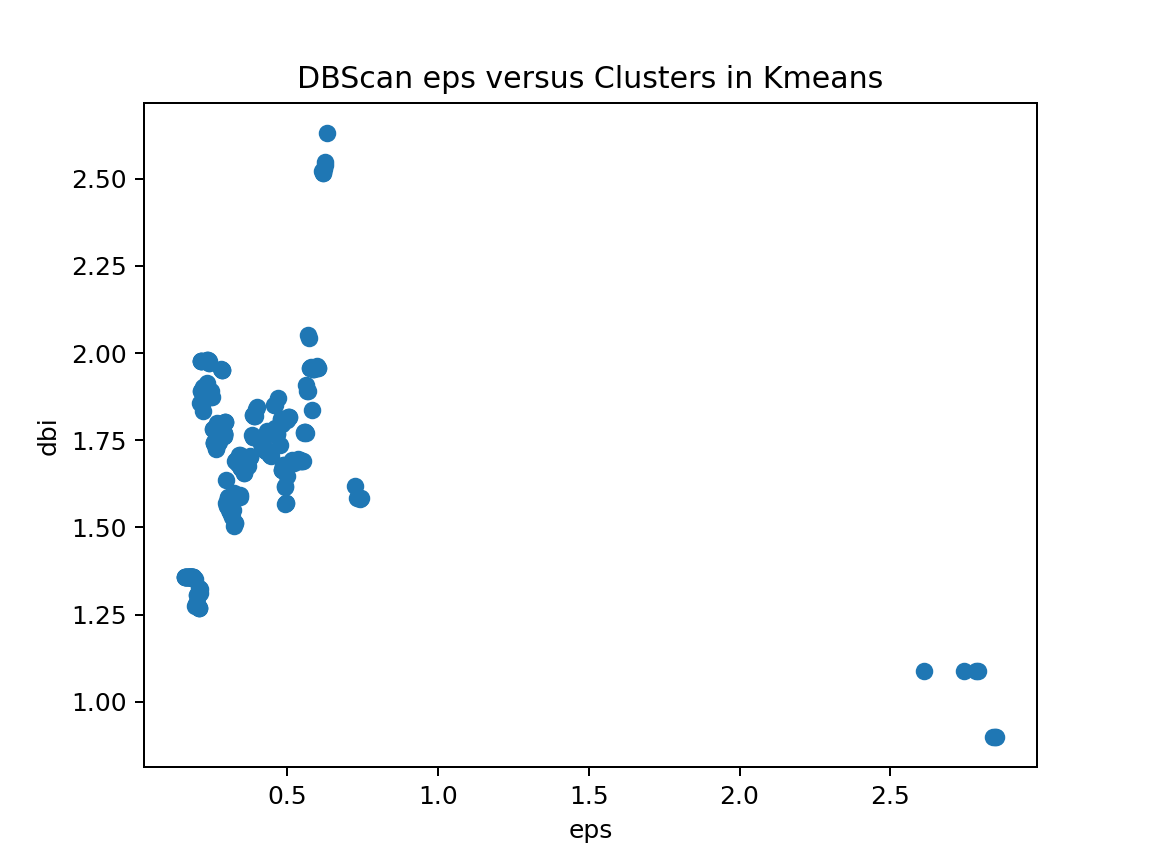

In [35]:
%matplotlib notebook
plt.scatter(lst_eps,db_dbis)
plt.xlabel('eps')
plt.ylabel('dbi')
plt.title('DBScan eps versus Clusters in Kmeans')
plt.show()

In [66]:
for k in good_clust.keys():
    if k>3 or k<.19:
        print(k, len(set(good_clust[k].labels_)))

0.175104 4


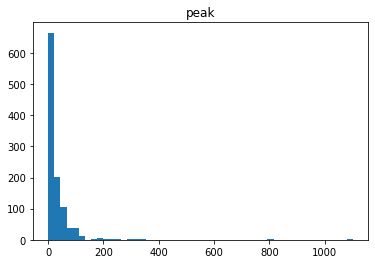

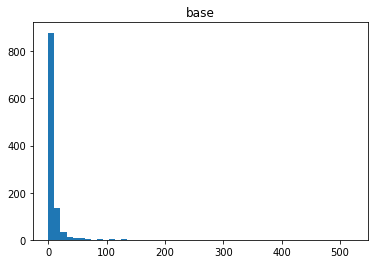

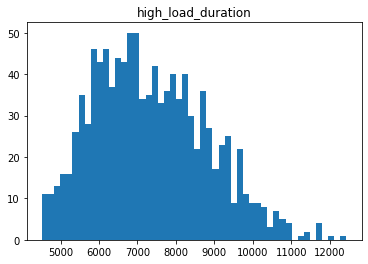

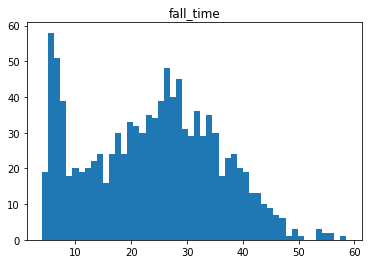

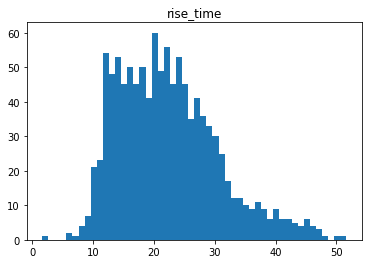

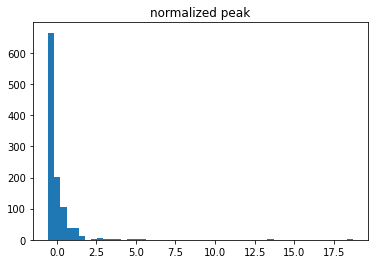

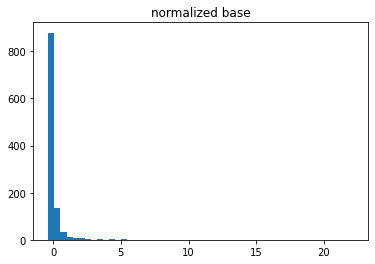

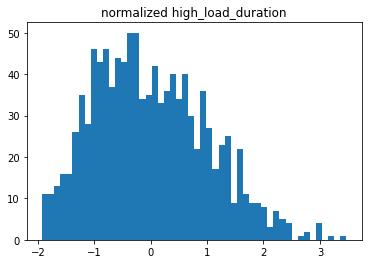

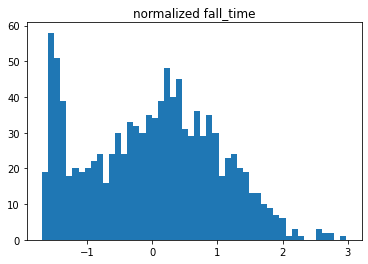

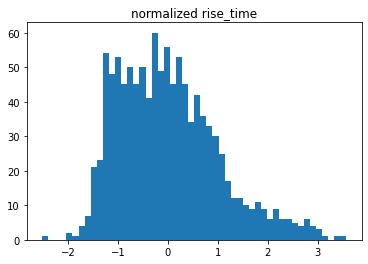

In [34]:
%matplotlib inline
params_lst = ['peak','base','high_load_duration','fall_time','rise_time']
for i in range(5):
    plt.hist(params[:,i],bins=50)
    plt.title(params_lst[i])
    plt.show()
    
for i in range(5):
    plt.hist(params_n[:,i],bins=50)
    plt.title('normalized '+params_lst[i])
    plt.show()

In [16]:
select_cluster = Kmeans(112).fit(params_n)

NameError: name 'Kmeans' is not defined

## Saving the clustering

In [15]:
np.save('kmeans112.npy',select_cluster.labels_)

In [53]:
lbls = select_cluster.labels_

In [54]:
lengths = []
for i in range(112):
    count = np.sum((lbls==i).astype(int))
    lengths.append(count)

<IPython.core.display.Javascript object>


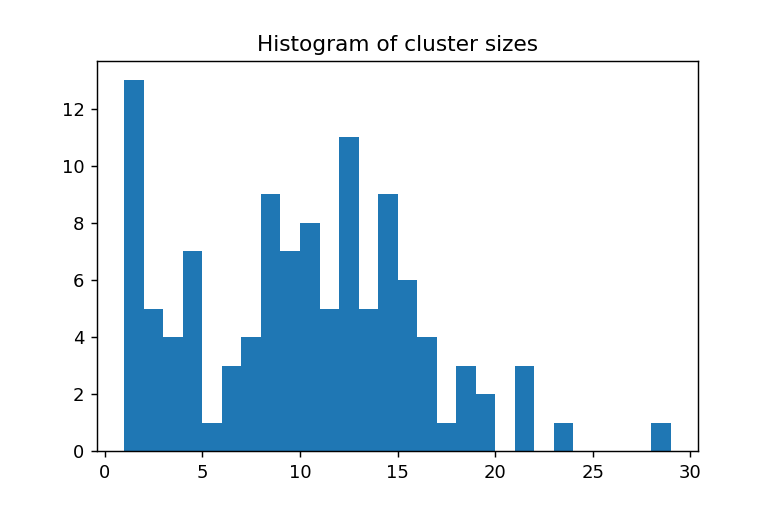

Text(0.5, 1.0, 'Histogram of cluster sizes')

In [69]:
plt.hist(lengths,bins=28)
plt.title('Histogram of cluster sizes')

## Various buildings per cluster. 
### each column is a cluster

<IPython.core.display.Javascript object>


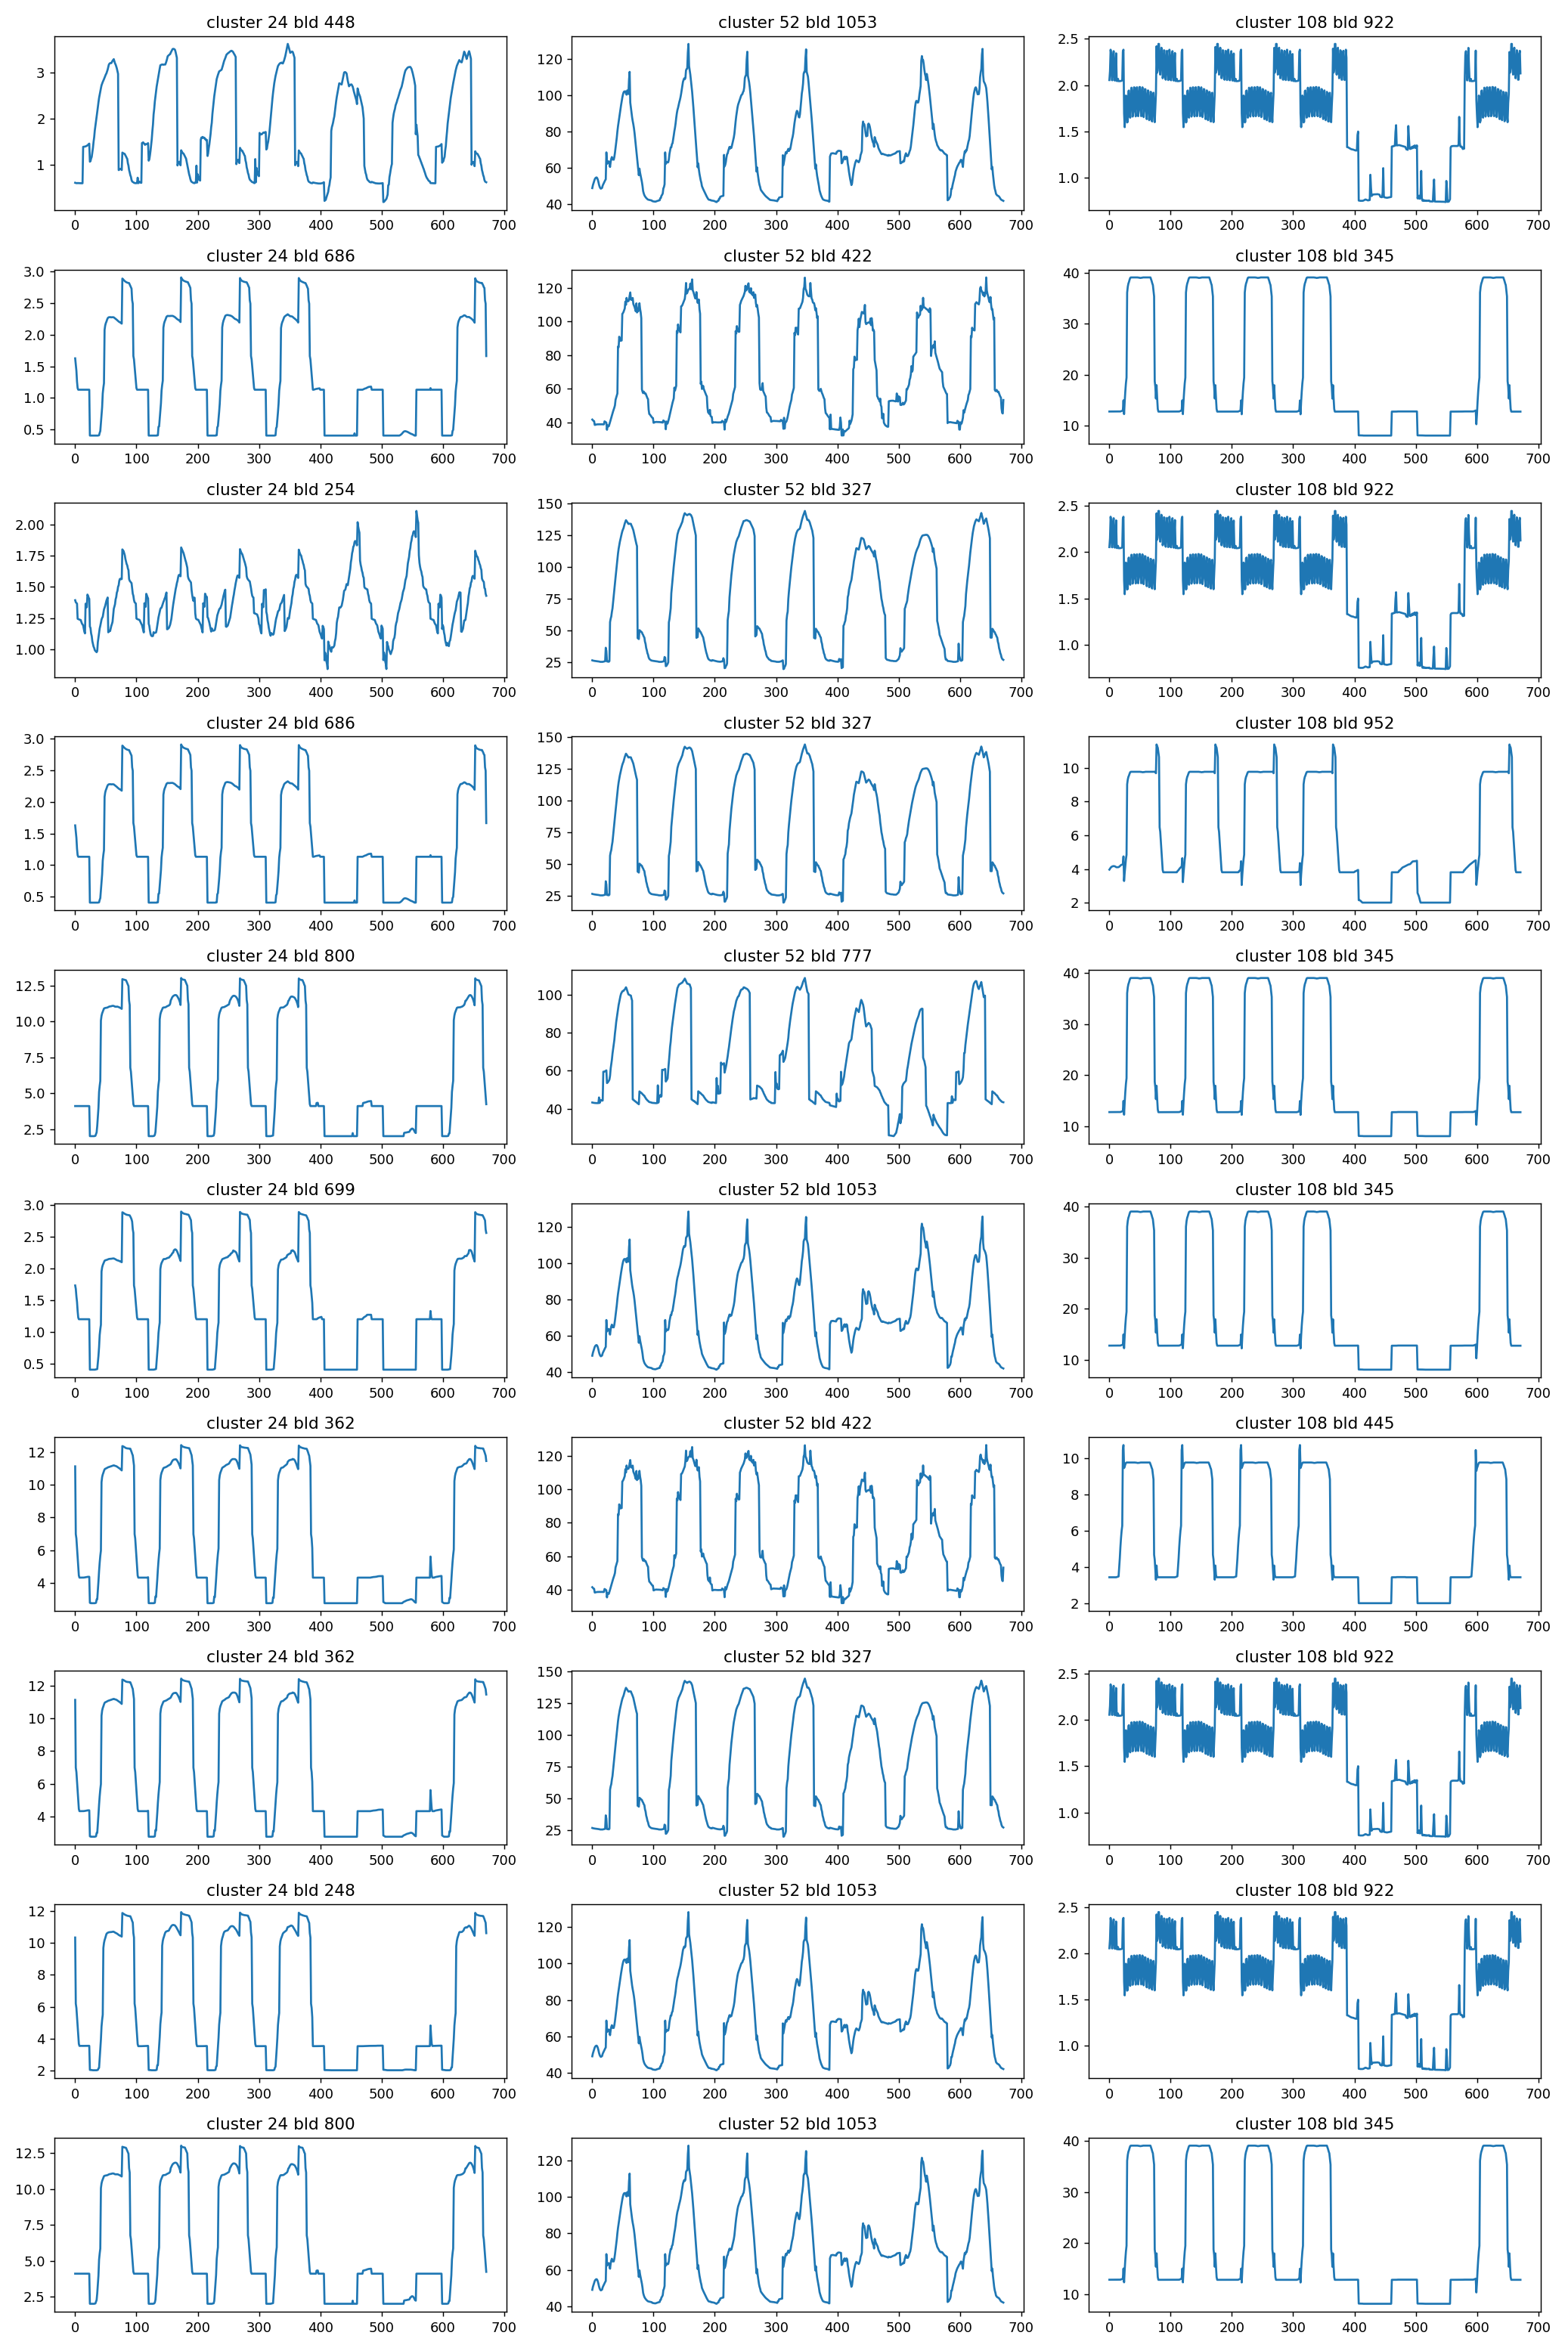

In [65]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()

<IPython.core.display.Javascript object>


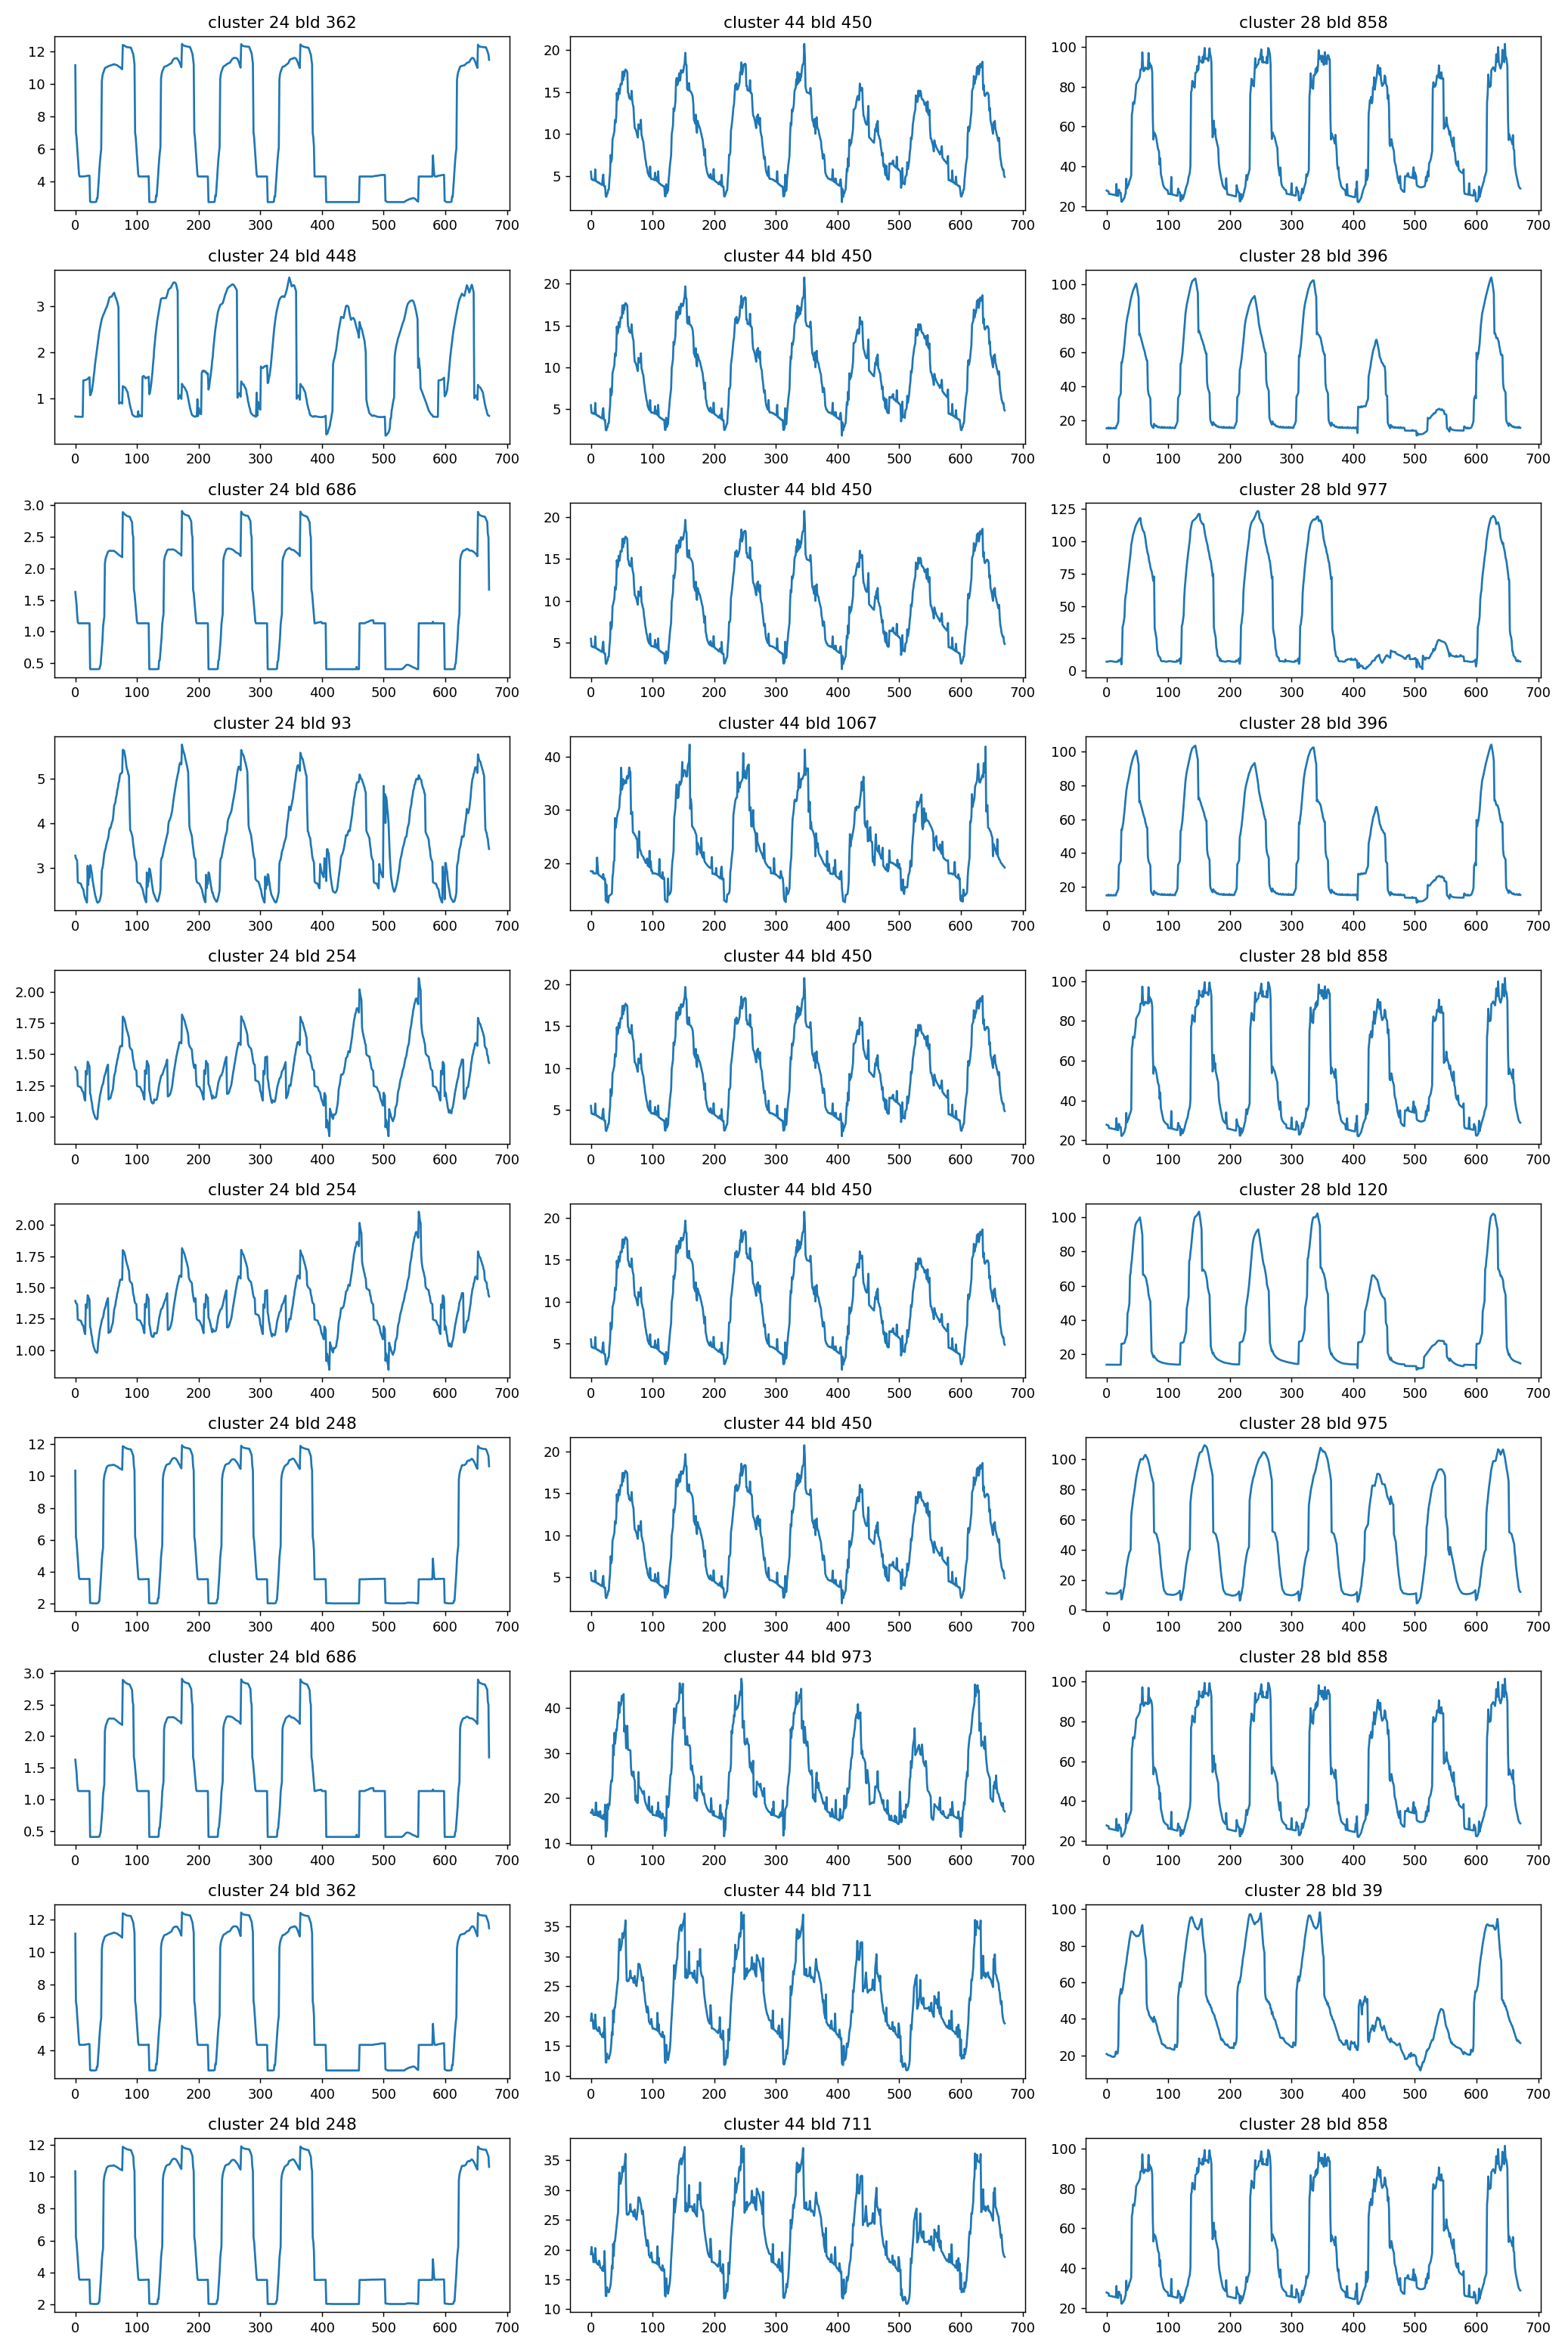

In [68]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


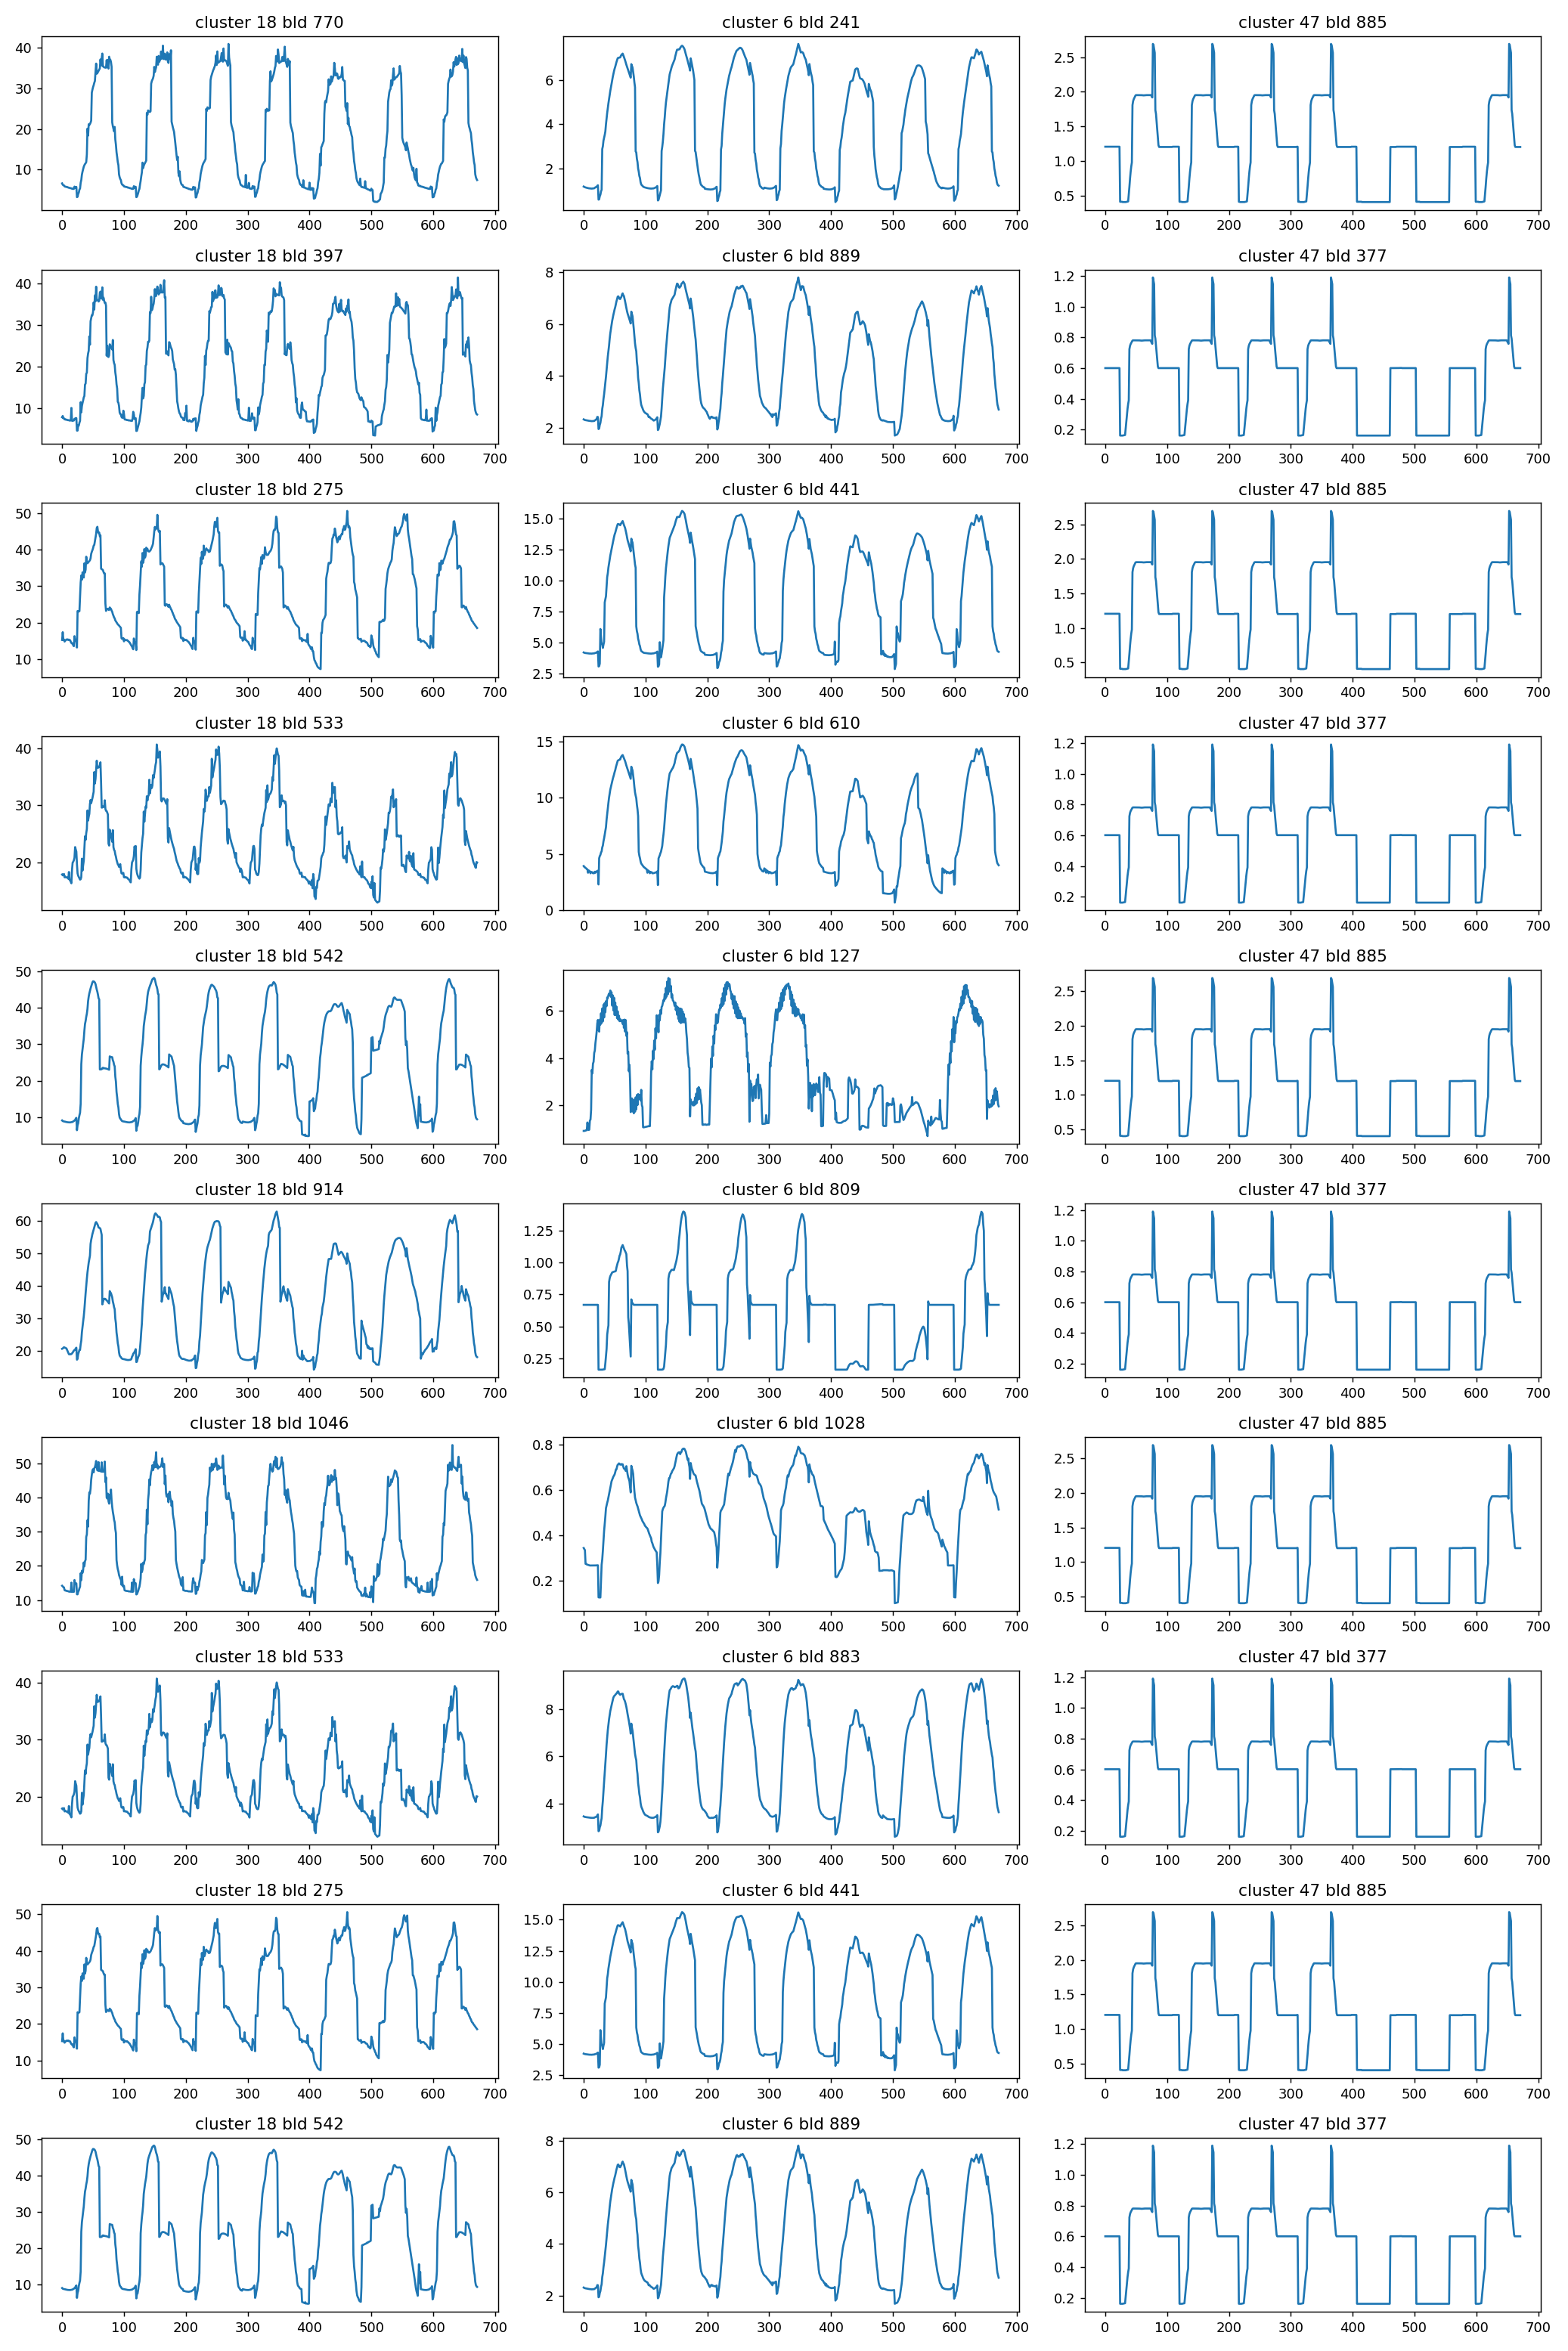

In [70]:
plt.subplots(10,3,figsize=(16,24))
clusters = np.random.randint(0,len(set(select_cluster.labels_)),3)
for i in range(10):
    for j in range(3):
        bld = np.random.choice(np.squeeze(np.argwhere((lbls==clusters[j]).astype(int)))) 
        plt.subplot(10,3,i*3+j+1)
        plt.plot(data[bld,:24*4*7])
        plt.title('cluster '+str(clusters[j])+' bld '+str(bld))
plt.tight_layout()
plt.show()